In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display

import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
import sys
sys.path.append('../../')
from metrics import anderson_darling, kendall_error

# Import data

In [3]:
data = pd.read_csv("../../data_train_log_return.csv", header=None).drop(columns=[0])
data.columns = [f'index{i}' for i in range(1, 5)]
data

,index1,index2,index3,index4
0,0.012495,0.011126,0.003252,0.006625
1,0.011439,0.002691,0.001206,0.006947
2,0.000632,0.007277,0.004049,0.000074
3,0.017828,0.028210,0.007758,0.007382
4,0.021115,0.019642,0.009238,0.011499
...,...,...,...,...
741,0.001938,0.008833,0.003927,0.005106
742,0.005003,0.018943,0.003057,0.001988
743,0.007683,0.001958,0.007002,0.006467
744,0.003396,0.001280,0.007621,0.001680


In [4]:
data = data.values

In [5]:
FILE = 'results.txt'

# VAE

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.15.0
Eager mode:  True
GPU is NOT AVAILABLE


### Create the model

In [8]:
class VAE(tf.keras.Model):

    def __init__(self, latent_dim, input_dim=data.shape[1]):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        
                tf.keras.layers.Reshape((input_dim, 1)), 
                tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
                tf.keras.layers.Flatten(),  
                tf.keras.layers.LayerNormalization(),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(32, activation='relu'),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Reshape((1, 128)), 
                tf.keras.layers.Conv1DTranspose(filters=32, kernel_size=3, activation='relu'),
                tf.keras.layers.Flatten(), 
                # No activation
                tf.keras.layers.Dense(input_dim)
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(data.shape[0], self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [9]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent)
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [10]:
def generate_samples(model, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    return predictions, mean, logvar, z

### Training

In [11]:
X = tf.cast(data, dtype=tf.float32)

In [12]:
def histogram(ax, data, label=""):
    sns.histplot(data, kde=True, ax=ax, stat='density', label=label)
    ax.legend()
    ax.set_ylabel('')
    ax.set_xlabel('')

def plot_distribution(model, generated_sample, title='', save=None):
    fig, axs = plt.subplots(4, 2, figsize=(11, 8))
    for i in range(4):
        histogram(axs[i][0], data[:, i], label=f'True index{i+1}')
        histogram(axs[i][1], generated_sample[:, i], label=f'Generated index{i+1}')
    for ax in axs:
        for ax_i in ax:
            ax_i.legend()

    #plt.tight_layout()
    plt.suptitle(title)
    if save is None:
        plt.show()
    else:
        plt.savefig(save)
        plt.close()

def plot_distribution_errors(model, generated_sample, errors):
    fig, axs = plt.subplots(4, 3, figsize=(14, 8))
    for i in range(4):
        histogram(axs[i][0], data[:, i], label=f'True index{i+1}')
        histogram(axs[i][1], generated_sample[:, i], label=f'Gen index{i+1}')

    axs[0][2].plot(errors['elbo'], label='ELBO')
    axs[0][2].grid('on')
    
    axs[1][2].plot(errors['anderson'], label='Anderson')
    axs[1][2].grid('on')

    axs[2][2].plot(errors['anderson'][-10:], label='Anderson - last 10')
    axs[2][2].grid('on')

    axs[3][2].plot(errors['kendall'], label='Kendall')
    axs[3][2].grid('on')

    for i, ax in enumerate(axs):
        for j, ax_j in enumerate(ax):
            ax_j.legend()

    plt.tight_layout()
    plt.show()

In [13]:
latent_dim = 5
model = VAE(latent_dim)

optimizer = tf.keras.optimizers.Adam(1e-3)
loss = tf.keras.metrics.Mean()

In [14]:
def compute_metrics(model, generated_sample, errors):
    random_anderson = anderson_darling(data, generated_sample.numpy())
    random_kendall = kendall_error(data, generated_sample.numpy())

    errors['anderson'].append(random_anderson)
    errors['kendall'].append(random_kendall)

In [15]:
errors = {}
errors['elbo'] = []
errors['anderson'] = []
errors['kendall'] = []

Epoch: 100000, ELBO: -180.2383575439453, time: 37.5394s for 1000 epochs


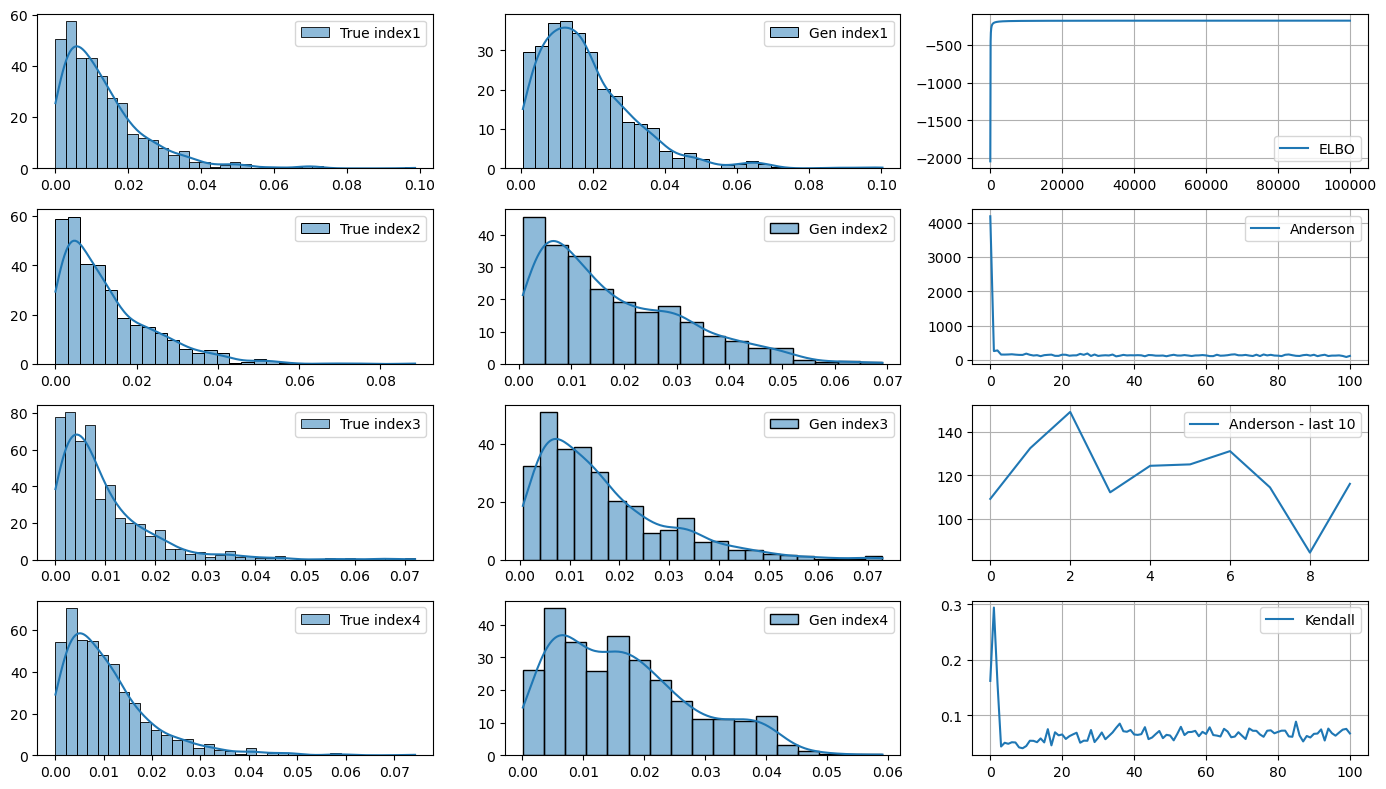

In [16]:
epochs = 100_000
display_every = 1000
patience = 1000
best_elbo = float('-inf')
no_improvement_count = 0

start_time = time.time()
for epoch in range(1, epochs + 1):
    train_step(model, X, optimizer)

    loss(compute_loss(model, X))
    elbo = -loss.result()
    errors['elbo'].append(elbo)

    # check for patience
    if elbo > best_elbo:
        best_elbo = elbo
        no_improvement_count = 0  # reset the counter
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        display.clear_output(wait=False)
        print(f'Patience! Epoch: {epoch}, ELBO: {elbo}')
        random_noise = np.random.exponential(2e-2, size=(data.shape))
        generated_sample, *_ = generate_samples(model, random_noise)
        plot_distribution_errors(model, generated_sample, errors)
        break

    if epoch % display_every == 0 or epoch == 1:
        display.clear_output(wait=False)
        random_noise = np.random.exponential(2e-2, size=(data.shape))
        generated_sample, *_ = generate_samples(model, random_noise)
        compute_metrics(model, generated_sample, errors)
        end_time = time.time()
        print(f"Epoch: {epoch}, ELBO: {elbo}, time: {round(end_time-start_time, 4)}s for {display_every} epochs")
        start_time = time.time()
        plot_distribution_errors(model, generated_sample, errors)

In [17]:
def redirect_to_file(model, f):
    sys.stdout = f
    model.summary()
    sys.stdout = sys.__stdout__

def write_architecture(model, file_=FILE):
    with open(file_, "a") as f:
        f.write(f"Latent dimension = {latent_dim}, dense: {len(model.encoder.layers) > 2} + Conv1D")
        redirect_to_file(model.encoder, f)
        f.write('\n')
        redirect_to_file(model.decoder, f)

## Generate new data

### Exponential noise

In [18]:
random_noise = np.random.exponential(2e-2, size=(data.shape))
generated_sample, *_ = generate_samples(model, random_noise)

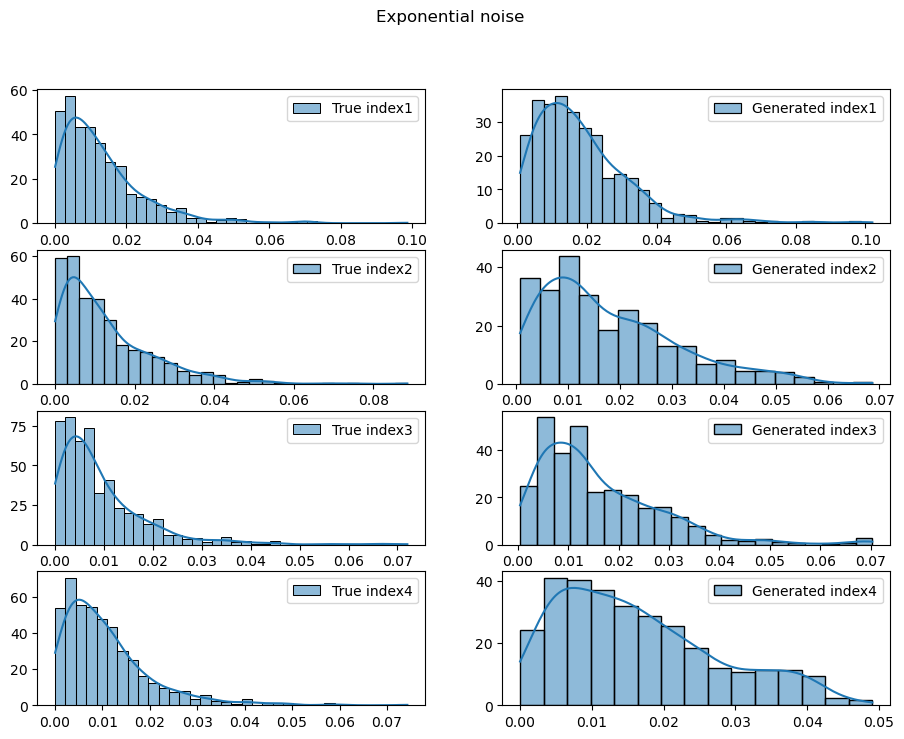

In [19]:
plot_distribution(model, generated_sample, title='Exponential noise')

In [20]:
anderson_darling(data, generated_sample.numpy())

119.03276586732889

In [21]:
kendall_error(data, generated_sample.numpy())

0.07118412292854957

In [22]:
tf.keras.losses.mean_squared_error(data, generated_sample).numpy().mean()

0.00031215363

### Gaussian noise

In [23]:
random_noise = np.random.normal(0, 2e-2, size=(data.shape))
generated_sample, *_ = generate_samples(model, random_noise)

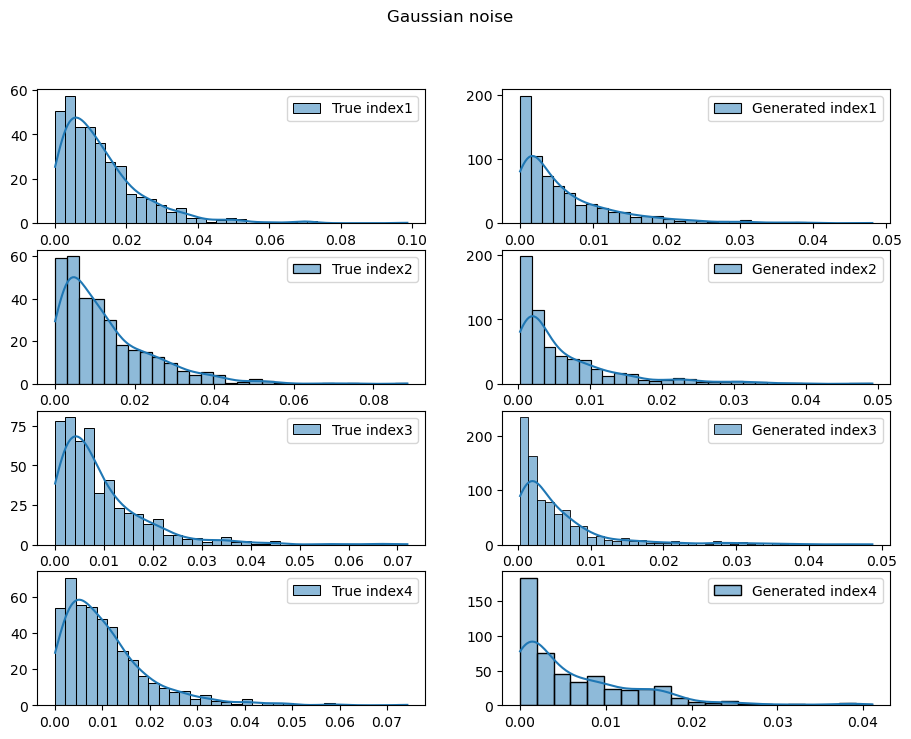

In [24]:
plot_distribution(model, generated_sample, title='Gaussian noise')

In [25]:
anderson_darling(data, generated_sample.numpy())

203.8517478616881

In [26]:
kendall_error(data, generated_sample.numpy())

0.09249329758713135

In [27]:
tf.keras.losses.mean_squared_error(data, generated_sample).numpy().mean()

0.00019199443

### Absolute Gaussian noise

In [28]:
random_noise = abs(np.random.normal(0, 2e-2, size=(data.shape)))
generated_sample, *_ = generate_samples(model, random_noise)

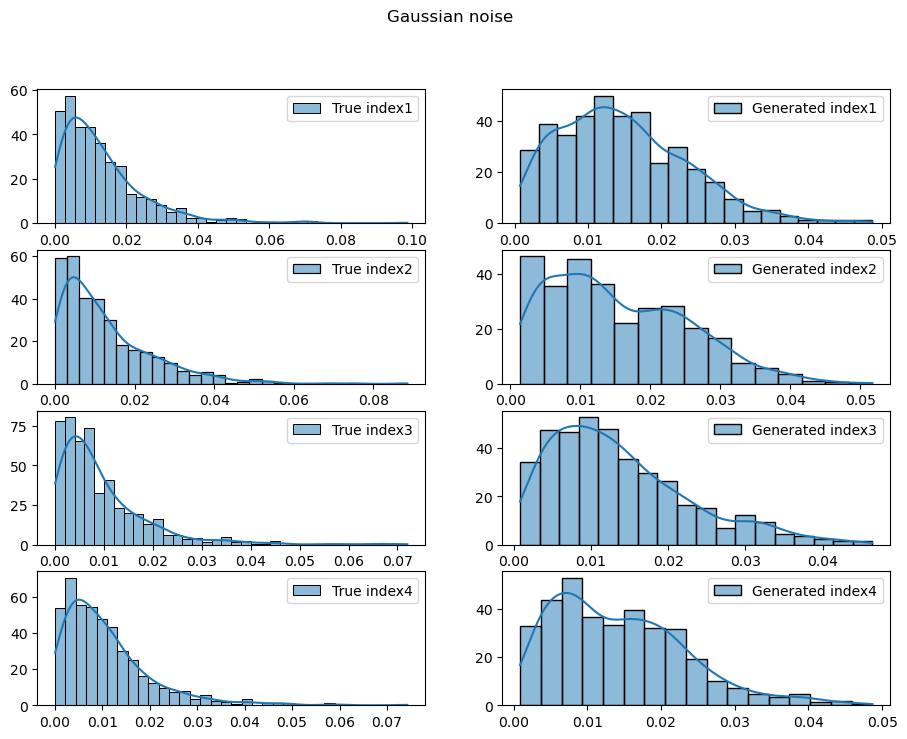

In [29]:
plot_distribution(model, generated_sample, title='Gaussian noise')

In [30]:
anderson_darling(data, generated_sample.numpy())

81.12418379827358

In [31]:
kendall_error(data, generated_sample.numpy())

0.07847670799071559

In [32]:
tf.keras.losses.mean_squared_error(data, generated_sample).numpy().mean()

0.00020872752

## Save results

In [33]:
import os

def save_latent_var(mean, logvar, z, file_):
    mean_df = pd.DataFrame(mean.numpy(), columns=[f'latent_mean_{i}' for i in range(mean.shape[1])])
    logvar_df = pd.DataFrame(logvar.numpy(), columns=[f'latent_logvar_{i}' for i in range(logvar.shape[1])])
    z_df = pd.DataFrame(z.numpy(), columns=['Gaussian_latent_var_feature_{i}' for i in range(z.shape[1])])
    all_df = pd.concat([mean_df, logvar_df, z_df], axis=1)
    all_df.to_csv(file_)

def write_noise(model, csv, images, file_=FILE, cv=50):
    noises = [np.random.exponential(1e-2, size=(data.shape)), np.random.normal(0, 1e-2, size=(data.shape)), abs(np.random.normal(0, 1e-2, size=(data.shape)))]
    names = ['Exponential noise: 1e-2', 'Gaussian noise: 0, 1e-2', 'Absolute value Gaussian noise: 0, 1e-2']
    filenames = ['exp', 'norm', 'abs_norm']
    
    def create_dir_if_not(dir_):
        if not os.path.isdir(dir_):
            os.mkdir(dir_)
    
    def compute_metrics_noise(noise, i):
        anderson = 0
        kendall = 0
        for _ in range(cv):
            generated_sample, mean, logvar, z = generate_samples(model, noise)
            anderson += anderson_darling(data, generated_sample.numpy())
            kendall += kendall_error(data, generated_sample.numpy())
        anderson /= cv
        kendall /= cv
        with open(file_, 'a') as f:
            f.write(f'Anderson: {anderson}, Kendall: {kendall}')
            
        create_dir_if_not(csv)
        csv_file = csv if csv.endswith('/') else csv + '/'
        csv_file += filenames[i] + '.csv'
        pd.DataFrame(generated_sample.numpy()).to_csv(csv_file, index=False)
        latent_file = csv if csv.endswith('/') else csv + '/'
        latent_file += filenames[i] + '_latent.csv'
        save_latent_var(mean, logvar, z, latent_file)
        
        create_dir_if_not(images)
        images_file = images if images.endswith('/') else images + '/'
        images_file += filenames[i] + '.png'
        plot_distribution(model, generated_sample, title=names[i], save=images_file)
    
    for i in range(len(noises)):
        with open(file_, 'a') as f:
            f.write('\n\n' + names[i] + '\n')
        compute_metrics_noise(noises[i], i)

In [34]:
write_architecture(model)

In [35]:
model.save_weights("./")

In [36]:
write_noise(model, './gen_samples', './gen_images', file_=FILE, cv=20)